In [5]:
from transformers import ResNetConfig,ResNetModel,BertTokenizer,Trainer
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torch
from torch import nn
import torchvision
from torchvision import transforms, datasets
import pickle

In [6]:
# tokenizer
tokenizer = BertTokenizer('./vocab.txt',)
# encoder
config_encoder = ResNetConfig()
model_encoder = ResNetModel(config=config_encoder)
# decoder
model_decoder = nn.Transformer(batch_first=True)

In [7]:
# 测试 tokenizer
test_caption = 'Krxk is a great developer.'
t = tokenizer.encode(test_caption,return_tensors='pt')
t = t.repeat((2, 1))
print(t)
print(t.shape)

tensor([[ 101,  180, 1197, 1775, 1377, 1110,  170, 1632, 9991,  119,  102],
        [ 101,  180, 1197, 1775, 1377, 1110,  170, 1632, 9991,  119,  102]])
torch.Size([2, 11])


In [8]:
# 加载 caption
# 纯数学公式
save_cwd = os.getcwd()

root_dir = 'F:/DP-Dataset/dataset-formula/'
os.chdir(root_dir)
train_dir = root_dir + 'train'
val_dir = root_dir + 'dev'

out_path_mid = root_dir.split('/')[-2].replace('dataset-', '') + '_'

with open(out_path_mid + 'train_out', 'rb') as f:
    train_labels = pickle.load(f)
    
with open(out_path_mid + 'dev_out', 'rb') as f:
    val_labels = pickle.load(f)
    
with open(out_path_mid + 'test_out', 'rb') as f:
    test_labels = pickle.load(f)
    
os.chdir(save_cwd)

In [9]:
train_labels, val_labels

({'id': ['0.txt',
   '1.txt',
   '10.txt',
   '100.txt',
   '1000.txt',
   '10001.txt',
   '10002.txt',
   '10003.txt',
   '10004.txt',
   '10005.txt',
   '10007.txt',
   '10008.txt',
   '1001.txt',
   '10010.txt',
   '10011.txt',
   '10012.txt',
   '10013.txt',
   '10014.txt',
   '10015.txt',
   '10016.txt',
   '10017.txt',
   '10019.txt',
   '1002.txt',
   '10021.txt',
   '10023.txt',
   '10024.txt',
   '10025.txt',
   '10026.txt',
   '10027.txt',
   '10028.txt',
   '10029.txt',
   '10031.txt',
   '10032.txt',
   '10034.txt',
   '10035.txt',
   '10036.txt',
   '10037.txt',
   '10038.txt',
   '10039.txt',
   '1004.txt',
   '10040.txt',
   '10042.txt',
   '10043.txt',
   '10044.txt',
   '10045.txt',
   '10046.txt',
   '10048.txt',
   '10050.txt',
   '10051.txt',
   '10052.txt',
   '10053.txt',
   '10055.txt',
   '10056.txt',
   '10057.txt',
   '10058.txt',
   '10059.txt',
   '1006.txt',
   '10061.txt',
   '10062.txt',
   '10065.txt',
   '10066.txt',
   '10068.txt',
   '1007.txt',
   '1

In [21]:
# 用于整合 Image 与 Caption，构造 Image-Caption 数据集
class Compose_Dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, image_dataset, caption_list):
        super().__init__()
        self.image_dataset = image_dataset
        self.caption_list = caption_list
        self.imgs = image_dataset.imgs
    def __getitem__(self, idx):
        index = self.caption_list['id'].index(self.imgs[idx][0].split('\\')[-1].replace('png', 'txt'))
        return self.image_dataset[idx][0], self.caption_list['label'][index]
    def __len__(self):
        return len(self.image_dataset)

In [37]:
pic_dir = 'F:/DP-Dataset/s'
data_args = transforms.Compose([
    transforms.Pad([200, 200]), # 填充
    transforms.Resize((200,200), interpolation=Image.Resampling.BICUBIC), # 调整为正方形并统一大小
    transforms.ToTensor()
])
data_set = datasets.ImageFolder(pic_dir, transform=data_args)

with open('F://DP-Dataset//s/formula_dev_out', 'rb') as f: # 打开格式化后的caption二进制文件
    label_list = pickle.load(f)
compose_dataset = Compose_Dataset(data_set, label_list)

batch_size = 32
data_iter = torch.utils.data.DataLoader(compose_dataset, batch_size=batch_size, shuffle=True)

C:\Users\12469\anaconda3\lib\site-packages\torchvision\transforms\transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


torch.Size([18, 3, 200, 200])
2 \sqrt{5}


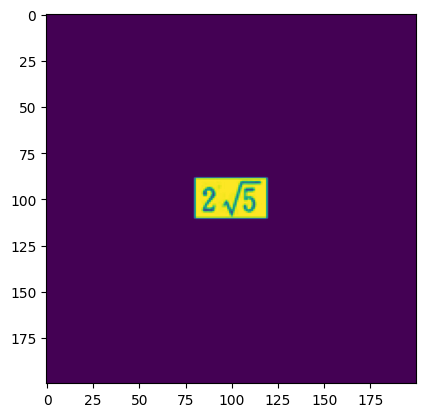

In [38]:
# 测试数据集
import matplotlib.pyplot as plt
for X, label in data_iter:
    # X 是一个 batch
    print(X.shape)
    test_id = 0
    print(label[test_id])
    plt.imshow(X[test_id][0]) # 查看 R 通道
    break

In [ ]:
# model
class Krxk_model(nn.Module):
    def __init__(self, tokenizer, encoder, decoder):
        super().__init__()
        self.tokenizer = tokenizer
        self.encoder = encoder
        self.embed_size = self.tokenizer.vocab_size
        self.transformer_encoder_in_nums = 512
        self.fc = nn.Sequential(nn.Flatten(), nn.Linear(2048 * 7 * 7, self.transformer_encoder_in_nums)) # 将 resnet 转化为 全连接
        self.embed = nn.Embedding(self.embed_size, self.transformer_encoder_in_nums) # 嵌入为 transformer的in_features维度
        self.decoder = decoder
        
        # 用作临时 caption 测试案例
        test_caption = 'Krxk is a great developer.' 
        print(test_caption)
        self.test_caption_tokenized = self.tokenizer.encode(test_caption, return_tensors='pt').repeat(6, 1) # 临时案例中有6张图片
        print(self.test_caption_tokenized.shape)
        print(self.embed(self.test_caption_tokenized).shape)
        
    def forward(self, X):
        encode = self.encoder(X).last_hidden_state
        features = self.fc(encode) # 将图片特征映射为词表特征
        
        # 此处将 embeddings 与 resnet 提取的特征进行concat 输入 transformer
#         embeddings = torch.concat((embeddings, embeddings), dim=1)
        embeddings = self.embed(self.test_caption_tokenized)
        f = features.unsqueeze(1)
        print(embeddings.shape, f.shape)
        embeddings = torch.concat((embeddings, features.unsqueeze(1)), dim=1)

        # decode 需要输入 src 与 tgt，分别用作 Transformer 编码器与解码器（输入正确的caption）的输入
        decode = self.decoder(embeddings, torch.ones_like(embeddings))
        return decode

In [ ]:
# 定义 model
model = Krxk_model(tokenizer ,model_encoder, model_decoder)

In [ ]:
# 图片测试
pic_dir = './pic/'
data_args = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])
data_set = datasets.ImageFolder(pic_dir, transform=data_args)
batch_size = 32
data_iter = torch.utils.data.DataLoader(data_set, batch_size=batch_size)

In [ ]:
# 模型测试
model.eval() # 评估模式运行减少计算量
for X, _ in data_iter:
    print(X.shape)
    generated_ids = model.forward(X)
    print(generated_ids.shape)
    break

In [ ]:
# 训练